### Подготовка данных

Загрузим тот же датасет и подгоним под формат удобный для pytorch

In [85]:
import torch
import idx2numpy
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import os

In [74]:
x_train = np.array(idx2numpy.convert_from_file('./data/emnist/emnist-letters-train-images-idx3-ubyte')).astype('float32')
y_train = np.array(idx2numpy.convert_from_file('./data/emnist/emnist-letters-train-labels-idx1-ubyte'))

x_test = np.array(idx2numpy.convert_from_file('./data/emnist/emnist-letters-test-images-idx3-ubyte')).astype('float32')
y_test = np.array(idx2numpy.convert_from_file('./data/emnist/emnist-letters-test-labels-idx1-ubyte'))

x_train /= 255
x_test /= 255

x_train = np.fliplr(x_train)
x_test = np.fliplr(x_test)

x_train = np.rot90(x_train, k=3, axes=(1, 2))
x_test = np.rot90(x_test, k=3, axes=(1, 2))

# x_train = x_train.reshape(x_train.shape[0], 784)
# x_test = x_test.reshape(x_test.shape[0], 784)

y_train -= 1
y_test -= 1

with open('data/emnist/emnist-letters-mapping.txt', 'r') as mapping_file:
    labels = {}
    for line in mapping_file.readlines():
        items = line.split()
        labels[int(items[0])-1] = chr(int(items[1]))

In [75]:
train_images = torch.tensor(x_train, dtype=torch.float32)
train_labels = torch.tensor(y_train, dtype=torch.float32)
test_images = torch.tensor(x_test, dtype=torch.float32)
test_labels = torch.tensor(y_test, dtype=torch.float32)

In [80]:
from torch.utils.data import Dataset, DataLoader

class EMNISTDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images.unsqueeze(1)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]
    
train_dataset = EMNISTDataset(train_images, train_labels)
test_dataset = EMNISTDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


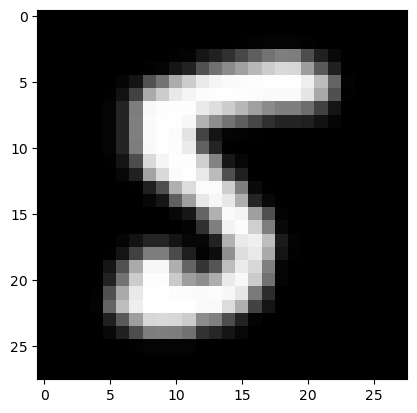

Label: 3.0


In [81]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

Вычисления попробуем производить на видеокарте

In [82]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [86]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 26)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [87]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=26, bias=True)
  )
)


In [93]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([8], device='cuda:0')
